# ROIC の Rank 継続を確認


In [ ]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from database_utils import DBHandler
from ROIC_make_data_files import (
    assign_roic_label,
    calculate_cumulative_return,
    calculate_roic_slope,
    calculate_winsorized_mean,
    plot_roic_label_cum_return,
    preprocess_from_factset_file,
)

warnings.simplefilter("ignore")

ROOT_DIR = Path().cwd().parent
DATA_DIR = ROOT_DIR / "data"
print(DATA_DIR)

ImportError: cannot import name 'preprocess_from_factset_file' from 'ROIC_make_data_files' (h:\HataY\03_Work\15_Quant\02_ROIC\src\ROIC_make_data_files.py)

## Factset 元データを加工


In [ ]:
preprocess_from_factset_file()

h:\HataY\03_Work\15_Quant\02_ROIC\data\MSCI KOKUSAI_weight.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data\MSCI KOKUSAI_Price.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data\MSCI KOKUSAI_ID.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data\MSCI KOKUSAI_ROIC.parquet has been exported.


# Make ROIC Label


In [ ]:
df_return_and_roic = pd.merge(
    pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_ROIC.parquet"),
    pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_ID.parquet"),
    how="left",
    on=["Identifier"],
).sort_values("date")

# ----- ROICの欠損値を埋める(1時点前の値) -----
df_return_and_roic_filled = (
    df_return_and_roic[["date", "Identifier", "ROIC"]]
    .sort_values(["Identifier", "date"])
    .groupby("Identifier")
    .apply(lambda group: group.ffill())
    .reset_index(drop=True)
)
df_return_and_roic_filled = (
    pd.merge(
        df_return_and_roic,
        df_return_and_roic_filled,
        on=["date", "Identifier"],
        suffixes=("", "_filled"),
    )
    .drop(columns=["ROIC"], axis=1)
    .rename(columns={"ROIC_filled": "ROIC"})
    .assign(
        SEDOL=lambda row: row["SEDOL"].str[:6],
        CUSIP=lambda row: row["CUSIP"].str[:8],
        ym=lambda row: row["date"].dt.year.astype(str)
        + row["date"].dt.month.astype(str).str.zfill(2),
    )
)

# weight of index constituents
df_weight = pd.read_parquet(
    DATA_DIR / "MSCI KOKUSAI_weight and full id.parquet"
).assign(
    ym=lambda df: df["date"].dt.year.astype(str)
    + df["date"].dt.month.astype(str).str.zfill(2)
)
col_first = [
    "date",
    "ym",
    "Name",
    "Symbol",
    "SEDOL",
    "CUSIP",
    "ISIN",
    "GICS_SECTOR",
    "GICS_INDUSTRY",
]
remain_cols = [col for col in df_weight.columns if col not in col_first]
df_weight = df_weight[col_first + remain_cols]

# merge
df_weight_sedol = pd.merge(
    df_weight.loc[df_weight["Symbol"].str.len() == 6]
    .drop(columns=["SEDOL", "CUSIP", "ISIN"])
    .rename(columns={"Symbol": "SEDOL"}),
    df_return_and_roic_filled.drop(
        columns=[
            "Identifier",
            "CUSIP",
            "ISIN",
            "SECTOR",
            "INDUSTRY",
            "INDGRP",
            "SUBIND",
            "date",
        ],
        axis=1,
    ),
    how="left",
    on=["ym", "SEDOL"],
).rename(columns={"SEDOL": "Symbol"})
df_weight_cusip = pd.merge(
    df_weight.loc[df_weight["Symbol"].str.len() == 8]
    .drop(columns=["SEDOL", "CUSIP", "ISIN"])
    .rename(columns={"Symbol": "CUSIP"}),
    df_return_and_roic_filled.drop(
        columns=[
            "Identifier",
            "SEDOL",
            "ISIN",
            "SECTOR",
            "INDUSTRY",
            "INDGRP",
            "SUBIND",
            "date",
        ],
        axis=1,
    ),
    how="left",
    on=["ym", "CUSIP"],
).rename(columns={"CUSIP": "Symbol"})

df_return_and_roic_filled = (
    pd.concat([df_weight_sedol, df_weight_cusip], axis=0)
    .dropna(subset=["weight", "Rtn_M"], axis=0, how="any")
    .sort_values(["date", "Symbol"], ignore_index=True)
    .assign(
        Quarter=lambda row: row["date"].dt.year.astype(str)
        + "Q"
        + row["date"].dt.quarter.astype(str),
    )
)

g_constituents_count = (
    df_weight.groupby("date")["weight"]
    .count()
    .reset_index()
    .rename(columns={"weight": "num_constituents"})
)

g = (
    df_return_and_roic_filled.groupby("date")["weight"]
    .agg(["count", "sum"])
    .reset_index()
    .rename(columns={"count": "num_avail_stocks", "sum": "total_weight"})
)
missing_roic = (
    df_return_and_roic_filled.groupby("date")["ROIC"]
    .apply(lambda x: x.isna().sum())
    .reset_index()
    .rename(columns={"ROIC": "num_ROIC_missing"})
)
g = pd.merge(g_constituents_count, g, on=["date"]).assign(
    cover_ratio=lambda row: row["num_avail_stocks"] / row["num_constituents"]
)
g = pd.merge(g, missing_roic, on=["date"]).reindex(
    [
        "date",
        "num_constituents",
        "num_avail_stocks",
        "cover_ratio",
        "total_weight",
        "num_ROIC_missing",
    ],
    axis=1,
)

df_return_and_roic_filled.sort_values(["date", "Symbol"], inplace=True)
# 1month forward return
df_return_and_roic_filled["Rtn_M_1MForward"] = df_return_and_roic_filled.groupby(
    "Symbol"
)["Rtn_M"].shift(-1)
for n in range(1, 21):
    df_return_and_roic_filled[f"ROIC_{n}QAgo"] = df_return_and_roic_filled.groupby(
        "Symbol"
    )["ROIC"].shift(n * 3)
    df_return_and_roic_filled[f"ROIC_{n}QForward"] = df_return_and_roic_filled.groupby(
        "Symbol"
    )["ROIC"].shift(-n * 3)

# forward ROIC: linear regression
roic_cols = [
    col
    for col in df_return_and_roic_filled.columns
    if ("ROIC" in col) and "QAgo" not in col and "20QForward" not in col
]
df_roic_lr = df_return_and_roic_filled.loc[
    df_return_and_roic_filled["date"].dt.month.isin([3, 6, 9, 12]),
    ["Quarter", "Symbol"] + roic_cols,
].drop_duplicates(ignore_index=True)

df_roic_lr["ROIC_Slope_20QForward"] = df_roic_lr.apply(
    calculate_roic_slope, quarter_period=20, axis=1
)
df_roic_lr["ROIC_Slope_12QForward"] = df_roic_lr.apply(
    calculate_roic_slope, quarter_period=12, axis=1
)

df_return_and_roic_filled = pd.merge(
    df_return_and_roic_filled,
    df_roic_lr[["Quarter", "Symbol", "ROIC_Slope_12QForward", "ROIC_Slope_20QForward"]],
    on=["Quarter", "Symbol"],
    how="left",
)

roic_cols_to_rank = [
    col
    for col in df_return_and_roic_filled.columns
    if (
        (("ROIC" in col)
        and ("QForward" in col)
        and ("Slope" not in col))
        or (col == "ROIC")
    )
]

for col in roic_cols_to_rank:
    target_col = ""
    if col == "ROIC":
        target_col = "ROIC_Rank"
    else:
        target_col = f"{col.replace('_', '_Rank_')}"
    df_return_and_roic_filled[target_col] = (
        df_return_and_roic_filled.groupby("Quarter")[col]
        .transform(
            lambda x: (
                pd.qcut(x, q=5, labels=False) + 1
                if x.notna().sum() >= 5
                else pd.Series(np.nan, index=x.index)
            )
        )
        .replace({1.0: "rank5", 2.0: "rank4", 3.0: "rank3", 4.0: "rank2", 5.0: "rank1"})
    )

df_return_and_roic_filled.to_parquet(DATA_DIR / "temp1.parquet")

# df_eoq_12Q = df_return_and_roic_filled.loc[
#     df_return_and_roic_filled["date"].dt.month.isin([3, 6, 9, 12])
# ]
df_eoq_20Q = df_return_and_roic_filled.loc[
    df_return_and_roic_filled["date"].dt.month.isin([3, 6, 9, 12])
]

# df_eoq_12Q["ROIC_Label_12QForward"] = df_return_and_roic_filled.apply(
#     assign_roic_label, quarter_period=12, judge_by_slope=False, axis=1
# ).reset_index(drop=True)
df_eoq_20Q["ROIC_Label_20QForward"] = df_return_and_roic_filled.apply(
    assign_roic_label, quarter_period=20, judge_by_slope=False, axis=1
).reset_index(drop=True)

# df_return_and_roic_filled_12Q = pd.merge(
#     df_return_and_roic_filled,
#     df_eoq_12Q[["Quarter", "Symbol", "ROIC_Label_12QForward"]],
#     on=["Quarter", "Symbol"],
#     how="left",
# )
df_return_and_roic_filled_20Q = pd.merge(
    df_return_and_roic_filled,
    df_eoq_20Q[["Quarter", "Symbol", "ROIC_Label_20QForward"]],
    on=["Quarter", "Symbol"],
    how="left",
)

# df_return_and_roic_filled_12Q.to_parquet(DATA_DIR / "temp12Q.parquet")
# df_return_and_roic_filled_20Q.to_parquet(DATA_DIR / "temp20Q.parquet")
df_return_and_roic_filled_20Q.to_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")

# df_eoq["ROIC_Label_20QForward"] = df_return_and_roic_filled.apply(
#     assign_roic_label, quarter_period=20, judge_by_slope=False, axis=1
# ).reset_index(drop=True)


# df_return_and_roic_filled = pd.merge(
#     df_return_and_roic_filled,
#     df_eoq[["Quarter", "Symbol", "ROIC_Label_12QForward", "ROIC_Label_20QForward"]],
#     on=["Quarter", "Symbol"],
#     how="left",
# )

# df_return_and_roic_filled = df_return_and_roic_filled.reindex(
#     columns=[
#         "date",
#         "Quarter",
#         "Name",
#         "Symbol",
#         "GICS_SECTOR",
#         "GICS_INDUSTRY",
#         "freq",
#         "weight",
#         "Rtn_M",
#         "Rtn_M_1MForward",
#     ]
#     + sorted([col for col in df_return_and_roic_filled.columns if "ROIC" in col])
# )

# display(df_return_and_roic_filled)

# Count the number of securities for each ROIC label


In [ ]:
# df20 = pd.read_parquet(DATA_DIR / "temp20Q.parquet")
df20 = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
display(df20)
g = pd.DataFrame(
    df20.groupby(["date"])["ROIC_Label_20QForward"].value_counts()
).reset_index()
g = pd.pivot(g, index="date", columns="ROIC_Label_20QForward", values="count")
display(g.dropna(how="any").tail(50))

,date,ym,Name,Symbol,GICS_SECTOR,GICS_INDUSTRY,weight,Rtn_M,freq,ROIC,...,ROIC_Rank_12QForward,ROIC_Rank_13QForward,ROIC_Rank_14QForward,ROIC_Rank_15QForward,ROIC_Rank_16QForward,ROIC_Rank_17QForward,ROIC_Rank_18QForward,ROIC_Rank_19QForward,ROIC_Rank_20QForward,ROIC_Label_20QForward
0,2005-05-31,200505,AFLAC INCORPORATED,00105510,Financials,Insurance,0.001170,0.022140,QUARTERLY,14.747015,...,rank2,rank2,rank2,rank2,rank1,rank2,rank1,rank1,rank1,remain high
1,2005-05-31,200505,AT&T INC,00206R10,Communication Services,Diversified Telecommunication Services,0.004315,-0.017647,QUARTERLY,6.950019,...,rank4,rank4,rank3,rank3,rank3,rank3,rank3,rank3,rank3,others
2,2005-05-31,200505,ABBOTT LABORATORIES,00282410,Health Care,Health Care Equipment & Supplies,0.003973,-0.018715,QUARTERLY,17.409870,...,rank2,rank2,rank2,rank1,rank1,rank1,rank1,rank1,rank1,others
3,2005-05-31,200505,ADOBE INC.,00724F10,Information Technology,Software,0.000878,0.113839,QUARTERLY,NaN,...,rank2,rank2,rank2,rank1,rank2,rank2,rank3,rank3,rank3,others
4,2005-05-31,200505,"ADVANCED MICRO DEVICES, INC.",00790310,Information Technology,Semiconductors & Semiconductor Equipment,0.000335,0.152495,QUARTERLY,0.650344,...,rank5,rank5,rank5,rank5,rank5,rank5,rank5,rank3,rank1,drop to low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196472,2025-03-31,202503,AERCAP HOLDINGS NV,N0098510,Industrials,Trading Companies & Distributors,0.000308,-0.009020,QUARTERLY,3.339097,...,None,None,None,None,None,None,None,None,None,others
196473,2025-03-31,202503,CNH INDUSTRIAL NV,N2094410,Industrials,Machinery,0.000167,-0.046584,QUARTERLY,3.730909,...,None,None,None,None,None,None,None,None,None,others
196474,2025-03-31,202503,LYONDELLBASELL INDUSTRIES NV,N5374510,Materials,Chemicals,0.000284,-0.083691,QUARTERLY,5.529184,...,None,None,None,None,None,None,None,None,None,others
196475,2025-03-31,202503,NXP SEMICONDUCTORS NV,N6596X10,Information Technology,Semiconductors & Semiconductor Equipment,0.000750,-0.118419,QUARTERLY,12.943815,...,None,None,None,None,None,None,None,None,None,others


ROIC_Label_20QForward,drop to low,move to high,others,remain high,remain low
date,,,,,
2016-05-31,59.0,61.0,442.0,140.0,112.0
2016-06-30,60.0,61.0,447.0,145.0,116.0
2016-07-29,66.0,46.0,474.0,138.0,106.0
2016-08-31,66.0,46.0,474.0,138.0,106.0
2016-09-30,66.0,46.0,475.0,138.0,106.0
2016-10-31,53.0,52.0,478.0,139.0,107.0
2016-11-30,53.0,52.0,479.0,139.0,107.0
2016-12-30,54.0,53.0,487.0,140.0,108.0
2017-01-31,56.0,58.0,491.0,136.0,101.0


# performance plot🔥


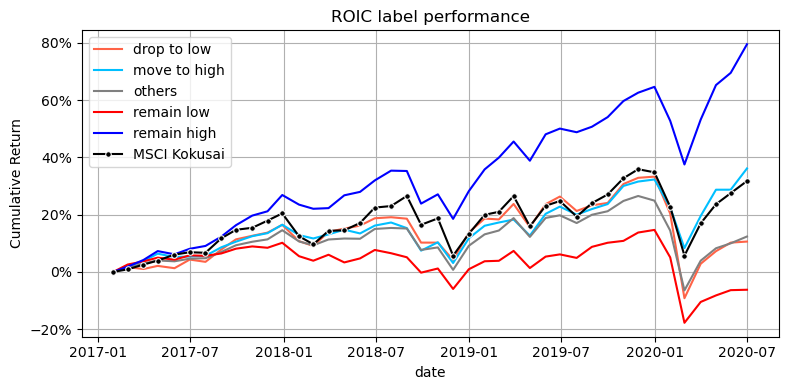

In [ ]:
roic_label_col = "ROIC_Label_20QForward"
start_date = "2017-01-01"

df_cum_return = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
date_list = [
    s
    for s in pd.to_datetime(df_cum_return["date"])
    .dt.strftime("%Y-%m-%d")
    .unique()
    .tolist()
]
date_list_str = "(" + ",".join(f"'{s}'" for s in date_list) + ")"

df_cum_return = calculate_cumulative_return(
    pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet").sort_index(),
    roic_label_col=roic_label_col,
    start_date=start_date,
)


db_handler = DBHandler(user_flg="default", db_environment="default")
query = f"""
SELECT IDX_ID, NENGAPPI_DT, IDX_VALUE
FROM TMA_ADMIN.TB_OTB422_INDEX_D
WHERE IDX_ID = 'GDDUKOK_WMRY'
AND NENGAPPI_DT IN {date_list_str}
"""
df_benchmark = (
    db_handler.write_to_pandas(sql=query)
    .rename(columns={"NENGAPPI_DT": "date", "IDX_VALUE": "MSCI Kokusai"})
    .reset_index(drop=True)
    .assign(
        ym=lambda row: row["date"].dt.year.astype(str)
        + row["date"].dt.month.astype(str).str.zfill(2)
    )
    .sort_values("date")
)

g = pd.DataFrame(df_benchmark.groupby("ym")["date"].max()).reset_index()
df_benchmark = (
    pd.merge(g, df_benchmark, on=["ym", "date"], how="left")
    .query(f"date>='{start_date}'")
    .assign(
        Rtn_M=lambda df: df["MSCI Kokusai"].pct_change(),
        Rtn_M_1MForward=lambda df: df["Rtn_M"].shift(-1),
        Index_cum_return=lambda df: (1 + df["Rtn_M_1MForward"]).cumprod() - 1,
    )
    .dropna(subset=["Rtn_M_1MForward"])
    .drop(columns=["ym"])
    .reset_index(drop=True)
)
df_benchmark["Index_cum_return"] = (
    df_benchmark["Index_cum_return"] - df_benchmark.loc[0, "Index_cum_return"]
)
# display(df_benchmark)

# merge
df_cum_return = pd.merge(
    df_cum_return,
    df_benchmark.set_index("date"),
    left_index=True,
    right_index=True,
    how="left",
)
# display(df_cum_return)


plot_roic_label_cum_return(
    df_cum_return, fig_title="ROIC label performance", show_benchmark=True
)

In [ ]:
# -----------------------------------------
start_date = "2017-01-01"
end_date = "2020-06-30"
# -----------------------------------------
df = (
    pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet").sort_values("date")
).set_index("date")

df = df.loc[start_date:end_date]
display(df)
g_sec_count = pd.DataFrame(
    df.groupby(["date", "ROIC_Rank", "ROIC_Rank_19QForward"])["Symbol"].count()
)
display(g_sec_count)


g = df.groupby(["ROIC_Rank", "ROIC_Rank_19QForward"])
mean_return = (
    pd.DataFrame(g["Rtn_M"].apply(calculate_winsorized_mean))
    .reset_index()
    .rename(
        columns={
            "ROIC_Rank": "ROIC_Current",
            "ROIC_Rank_19QForward": "ROIC_5Y_Later",
            "": "Rtn_M",
        }
    )
)
mean_return = pd.pivot(
    mean_return, index="ROIC_Current", columns="ROIC_5Y_Later", values="Rtn_M"
)
display(mean_return)

,ym,Name,Symbol,GICS_SECTOR,GICS_INDUSTRY,weight,Rtn_M,freq,ROIC,Quarter,...,ROIC_Rank_12QForward,ROIC_Rank_13QForward,ROIC_Rank_14QForward,ROIC_Rank_15QForward,ROIC_Rank_16QForward,ROIC_Rank_17QForward,ROIC_Rank_18QForward,ROIC_Rank_19QForward,ROIC_Rank_20QForward,ROIC_Label_20QForward
date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,201701,"SERVICENOW, INC.",81762P10,Information Technology,Software,0.000475,0.218994,QUARTERLY,-46.671050,2017Q1,...,rank1,rank1,rank1,rank1,rank4,rank4,rank4,rank4,rank4,others
2017-01-31,201701,"S&P GLOBAL, INC.",78409V10,Financials,Capital Markets,0.001010,0.117538,QUARTERLY,53.478920,2017Q1,...,rank1,rank1,rank1,rank1,rank1,rank1,rank1,rank1,rank1,remain high
2017-01-31,201701,SBA COMMUNICATIONS CORP. CLASS A,78410G10,Real Estate,Specialized REITs,0.000418,0.019369,QUARTERLY,1.175788,2017Q1,...,rank5,rank5,rank5,rank5,rank5,rank4,rank4,rank4,rank5,remain low
2017-01-31,201701,SEI INVESTMENTS COMPANY,78411710,Financials,Capital Markets,0.000212,-0.017220,QUARTERLY,25.749200,2017Q1,...,rank1,rank1,rank1,rank1,rank1,rank1,rank1,rank1,rank1,remain high
2017-01-31,201701,"SALESFORCE, INC.",79466L30,Information Technology,Software,0.001621,0.155419,QUARTERLY,2.084636,2017Q1,...,rank5,rank5,rank3,rank2,rank2,rank2,rank4,rank5,rank5,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,202006,DANSKE BANK A/S,458882,Financials,Banks,0.000238,0.063871,QUARTERLY,0.580065,2020Q2,...,rank5,rank5,rank5,rank5,rank5,rank5,rank5,rank5,None,remain low
2020-06-30,202006,"INTERCONTINENTAL EXCHANGE, INC.",45866F10,Financials,Capital Markets,0.001317,-0.058098,QUARTERLY,8.804800,2020Q2,...,rank4,rank4,rank4,rank4,rank4,rank4,rank4,rank4,None,move to high
2020-06-30,202006,INTEL CORPORATION,45814010,Information Technology,Semiconductors & Semiconductor Equipment,0.006648,-0.049261,QUARTERLY,21.626790,2020Q2,...,rank5,rank5,rank5,rank5,rank5,rank5,rank5,rank5,None,move to high


Symbol
date       ROIC_Rank ROIC_Rank_19QForward        
2017-01-31 rank1     rank1                     93
                     rank2                     35
                     rank3                     19
                     rank4                      5
                     rank5                     11
...                                           ...
2020-06-30 rank5     rank1                     22
                     rank2                     27
                     rank3                     28
                     rank4                     63
                     rank5                     85

[1050 rows x 1 columns]

ROIC_5Y_Later,rank1,rank2,rank3,rank4,rank5
ROIC_Current,,,,,
rank1,0.014013,0.009912,0.011441,0.010449,0.013655
rank2,0.015903,0.008248,0.007388,0.003614,0.008886
rank3,0.010681,0.007275,0.005112,0.002844,0.001646
rank4,0.010590,0.003146,0.001714,0.005626,0.003665
rank5,0.010479,0.005618,0.003031,0.002415,0.002984


In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
df.to_excel(DATA_DIR / "MSCI KOKUSAI_all data.xlsx", index=False)

In [ ]:
# df = pd.read_parquet(DATA_DIR / "temp3_1.parquet")
# # display(df)
# df_remain_high = df.loc[
#     (df["ROIC_Label_12QForward"] == "remain high")
#     & (df["ROIC_Label_20QForward"] == "remain high")
# ]
# g = pd.DataFrame(df_remain_high.groupby(["date"])["Symbol"].count()).reset_index()
# display(g)


# g1 = pd.DataFrame(
#     df.groupby(["date", "ROIC_Label_12QForward"])["Symbol"].count().sort_index()
# ).reset_index()
# g1 = pd.pivot(g1, index="date", columns="ROIC_Label_12QForward", values="Symbol")
# g2 = pd.DataFrame(
#     df.groupby(["date", "ROIC_Label_20QForward"])["Symbol"].count().sort_index()
# ).reset_index()
# g2 = pd.pivot(g2, index="date", columns="ROIC_Label_20QForward", values="Symbol")
# display(g1.loc["2018-01-01":"2023-01-01"])
# display(g2.loc["2018-01-01":"2023-01-01"])


,date,Quarter,Name,Symbol,GICS_SECTOR,GICS_INDUSTRY,freq,weight,Rtn_M,Rtn_M_1MForward,...,ROIC_Rank_2QForward,ROIC_Rank_3QForward,ROIC_Rank_4QForward,ROIC_Rank_5QForward,ROIC_Rank_6QForward,ROIC_Rank_7QForward,ROIC_Rank_8QForward,ROIC_Rank_9QForward,ROIC_Slope_12QForward,ROIC_Slope_20QForward
0,2005-05-31,2005Q2,AFLAC INCORPORATED,00105510,Financials,Insurance,QUARTERLY,0.001170,0.022140,0.041637,...,rank2,rank2,rank2,rank2,rank2,rank2,rank2,rank2,0.035661,-0.046071
1,2005-05-31,2005Q2,AT&T INC,00206R10,Communication Services,Diversified Telecommunication Services,QUARTERLY,0.004315,-0.017647,0.015826,...,rank4,rank4,rank4,rank4,rank3,rank4,rank4,rank4,0.050858,-0.001794
2,2005-05-31,2005Q2,ABBOTT LABORATORIES,00282410,Health Care,Health Care Equipment & Supplies,QUARTERLY,0.003973,-0.018715,0.015963,...,rank2,rank2,rank2,rank2,rank2,rank4,rank4,rank4,-0.761336,0.129801
3,2005-05-31,2005Q2,ADOBE INC.,00724F10,Information Technology,Software,QUARTERLY,0.000878,0.113839,-0.136171,...,rank1,rank2,rank2,rank3,rank3,rank3,rank3,rank3,-1.734387,-0.768109
4,2005-05-31,2005Q2,"ADVANCED MICRO DEVICES, INC.",00790310,Information Technology,Semiconductors & Semiconductor Equipment,QUARTERLY,0.000335,0.152495,0.057317,...,rank5,rank5,rank4,rank4,rank4,rank5,rank5,rank5,-4.138308,-1.400182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192029,2025-03-31,2025Q1,AERCAP HOLDINGS NV,N0098510,Industrials,Trading Companies & Distributors,QUARTERLY,0.000308,-0.009020,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN
192030,2025-03-31,2025Q1,CNH INDUSTRIAL NV,N2094410,Industrials,Machinery,QUARTERLY,0.000167,-0.046584,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN
192031,2025-03-31,2025Q1,LYONDELLBASELL INDUSTRIES NV,N5374510,Materials,Chemicals,QUARTERLY,0.000284,-0.083691,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN
192032,2025-03-31,2025Q1,NXP SEMICONDUCTORS NV,N6596X10,Information Technology,Semiconductors & Semiconductor Equipment,QUARTERLY,0.000750,-0.118419,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN


ROIC_Label_12QForward,drop to low,move to high,others,remain high,remain low
date,,,,,
2016-01-29,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-29,0.094113,0.043637,0.060213,0.054544,0.044607
2016-03-31,0.188034,0.060288,0.067517,0.048499,0.072084
2016-04-29,0.162250,0.081101,0.084726,0.080155,0.077689
2016-05-31,0.197765,0.052959,0.072237,0.078179,0.029371
2016-06-30,0.278527,0.122233,0.116725,0.127742,0.073372
2016-07-29,0.278113,0.132187,0.123579,0.129045,0.086036
2016-08-31,0.313290,0.133583,0.125359,0.134222,0.080709
2016-09-30,0.293179,0.079627,0.114048,0.111338,0.095688


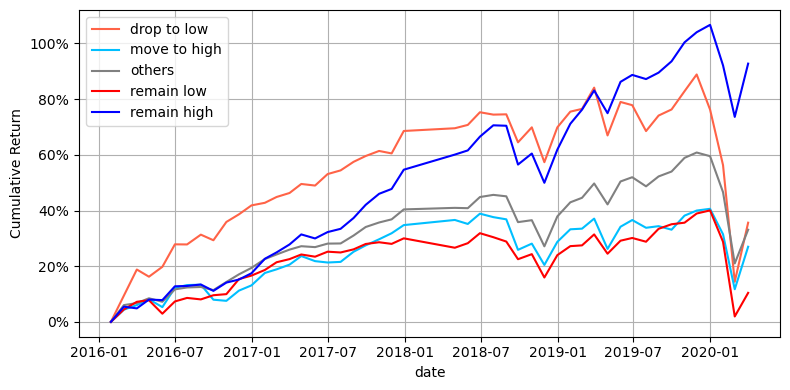

In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
display(df)
roic_label_col = "ROIC_Label_12QForward"


df_cum_return = calculate_cumulative_return(
    df,
    roic_label_col=roic_label_col,
    start_date="2016-01-01",
)


display(df_cum_return)
plot_roic_label_cum_return(df_cum_return)


# g3y = (
#     df[["Quarter", "Symbol", "ROIC_Label_12QForward"]]
#     .drop_duplicates(ignore_index=True)
#     .groupby(["Quarter", "ROIC_Label_12QForward"])["Symbol"]
#     .count()
#     .reset_index()
# )
# g3y = pd.pivot(g3y, index="Quarter", columns="ROIC_Label_12QForward", values="Symbol")
# g5y = (
#     df[["Quarter", "Symbol", "ROIC_Label_20QForward"]]
#     .drop_duplicates(ignore_index=True)
#     .groupby(["Quarter", "ROIC_Label_20QForward"])["Symbol"]
#     .count()
#     .reset_index()
# )
# g5y = pd.pivot(g5y, index="Quarter", columns="ROIC_Label_20QForward", values="Symbol")
# display(g3y.tail(50))
# display(g5y.tail(50))

In [ ]:
df_filter = df[["date", "Symbol", "ROIC_Label_12QForward"]].drop_duplicates(
    ignore_index=True
)
display(df_filter)

,date,Symbol,ROIC_Label_12QForward
0,2005-05-31,00105510,remain high
1,2005-05-31,00206R10,others
2,2005-05-31,00282410,others
3,2005-05-31,00724F10,others
4,2005-05-31,00790310,others
...,...,...,...
192029,2025-03-31,N0098510,others
192030,2025-03-31,N2094410,others
192031,2025-03-31,N5374510,others
192032,2025-03-31,N6596X10,others


In [ ]:
# df_weight = (
#     pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_weight.parquet")
#     .rename(columns={"variable": "date"})
#     .drop_duplicates(ignore_index=True)
# )
# df_weight.to_excel(
#     DATA_DIR / "MSCI_KOKUSAI_weight.xlsx",
#     index=False,
# )
# display(df_weight)
# display(df_weight[df_weight[["Symbol", "date"]].duplicated()])

df_weight = pd.read_excel(DATA_DIR / "MSCI KOKUSAI_weight and full id.xlsx")
df_weight.to_parquet(DATA_DIR / "MSCI KOKUSAI_weight and full id.parquet", index=False)

# df_weight_wide = pd.pivot(
#     df_weight[["date", "Symbol", "weight"]],
#     index="date",
#     columns="Symbol",
#     values="weight",
# )


# display(df_weight_wide)

つづき


In [ ]:
df_quarterly_return = pd.read_parquet(
    DATA_DIR / "MSCI KOKUSAI_Price.parquet"
).set_index("date")

df_quarterly_return = pd.DataFrame(df_quarterly_return.pct_change(3)).reset_index()
df_quarterly_return = pd.melt(
    df_quarterly_return, id_vars=["date"], var_name="Identifier", value_name="Rtn_3M"
)

df_roic = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_ROIC.parquet")
df_roic = pd.merge(df_roic, df_quarterly_return, on=["date", "Identifier"], how="left")
# display(df_roic)


df_roic["ROIC_Rank"] = (
    df_roic.groupby(["date"])["ROIC"]
    .transform(
        lambda x: (
            pd.qcut(x, q=5, labels=False) + 1
            if x.notna().sum() >= 5
            else pd.Series(np.nan, index=x.index)
        )
    )
    .replace({1.0: "rank5", 2.0: "rank4", 3.0: "rank3", 4.0: "rank2", 5.0: "rank1"})
)


df_roic = df_roic.assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    Quarter=lambda x: x["date"].dt.year.astype(str)
    + "Q"
    + x["date"].dt.quarter.astype(str),
)


df_id = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_ID.parquet")


df_roic = pd.merge(
    df_roic, df_id[["Identifier", "SEDOL", "SECTOR"]], on=["Identifier"], how="left"
).drop(columns=["Identifier", "ROIC"])

df_end_of_Q = df_roic.loc[df_roic["month"].isin([3, 6, 9, 12])].reset_index(drop=True)
df_monthly = df_roic.copy()

df_shift = df_end_of_Q.copy()[["Quarter", "SEDOL", "ROIC_Rank"]].sort_values(
    ["SEDOL", "Quarter"]
)
for n_ago in range(1, 21):
    df_shift[f"ROIC_Rank_{n_ago}QAgo"] = df_shift.groupby("SEDOL")["ROIC_Rank"].shift(
        n_ago
    )
df_shift = df_shift.set_index(["Quarter", "SEDOL"]).dropna(
    how="any"
)  # drop if there are any missing ROIC_Rank
# display(df_shift)


df_roic = (
    df_shift.copy()
    .assign(ROIC_Label=lambda df: df.apply(assign_roic_label, axis=1))
    .reset_index()
)

g_label_count = df_roic.pivot_table(
    index="Quarter", columns="ROIC_Label", values="SEDOL", aggfunc="count", fill_value=0
).assign(num_total=lambda df: df.sum(axis=1))
display(g_label_count)
# export
g_label_count.to_parquet(DATA_DIR / "MSCI KOKUSAI_ROIC Label Count.parquet")

df_roic_performance = pd.merge(
    df_monthly,
    df_roic[["Quarter", "SEDOL", "ROIC_Label"]],
    on=["Quarter", "SEDOL"],
    how="inner",
).dropna(subset=["Rtn_M", "ROIC_Label"], how="any")
display(df_roic_performance)

# export
df_roic_performance.to_parquet(DATA_DIR / "MSCI KOKUSAI_ROIC Label and Return.parquet")

ROIC_Label,drop to low,move to high,others,remain high,remain low,num_total
Quarter,,,,,,
2010Q2,43,36,361,108,82,630
2010Q3,39,44,374,110,82,649
2010Q4,45,40,389,113,81,668
2011Q1,49,41,402,113,83,688
2011Q2,49,37,415,117,85,703
2011Q3,45,41,419,122,88,715
2011Q4,46,54,410,127,94,731
2012Q1,48,50,417,128,93,736
2012Q2,48,44,418,134,96,740


,date,Rtn_M,Rtn_3M,ROIC_Rank,year,month,Quarter,SEDOL,SECTOR,ROIC_Label
0,2010-04-30,0.061027,0.101628,rank1,2010,4,2010Q2,2595708,Industrials,remain high
1,2010-05-28,-0.105560,-0.010480,rank1,2010,5,2010Q2,2595708,Industrials,remain high
2,2010-06-30,-0.004035,-0.054804,rank1,2010,6,2010Q2,2595708,Industrials,remain high
3,2010-07-30,0.082922,-0.035299,rank1,2010,7,2010Q3,2595708,Industrials,remain high
4,2010-08-31,-0.081716,-0.009583,rank1,2010,8,2010Q3,2595708,Industrials,remain high
...,...,...,...,...,...,...,...,...,...,...
151399,2024-11-29,0.076401,0.235827,rank1,2024,11,2024Q4,B23FN39,Consumer Discretionary,remain high
151400,2024-12-31,0.192572,0.409287,rank1,2024,12,2024Q4,B23FN39,Consumer Discretionary,remain high
151401,2025-01-31,0.083131,0.390399,rank1,2025,1,2025Q1,B23FN39,Consumer Discretionary,remain high
151402,2025-02-28,-0.117310,0.140180,rank1,2025,2,2025Q1,B23FN39,Consumer Discretionary,remain high


### Calculate: cumulative return for each ROIC label


In [ ]:
def calculate_clipped_mean(group):
    """グループ内のRtn_Mの平均値をクリップして計算する関数"""
    lower_bound = group["Rtn_M"].quantile(0.05)
    upper_bound = group["Rtn_M"].quantile(0.95)
    clipped_values = group["Rtn_M"].clip(lower=lower_bound, upper=upper_bound)
    return clipped_values.mean()


df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_ROIC Label and Return.parquet")
g_mean = (
    df.groupby(["date", "ROIC_Label"])
    .apply(calculate_clipped_mean)
    .reset_index(name="Label_Avg_Rtn_M")
)
df = pd.merge(df, g_mean, on=["date", "ROIC_Label"], how="left")

display(df)


g = (
    df.groupby(["date", "ROIC_Label"])["Rtn_M"]
    .agg(["mean", "std", "max", "median", "min", "count"])
    .reset_index()
)
display(g.loc[g["date"] >= "2024-01-01"].head(50))

,date,Rtn_M,Rtn_3M,ROIC_Rank,year,month,Quarter,SEDOL,SECTOR,ROIC_Label,Label_Avg_Rtn_M
0,2010-04-30,0.061027,0.101628,rank1,2010,4,2010Q2,2595708,Industrials,remain high,0.020134
1,2010-05-28,-0.105560,-0.010480,rank1,2010,5,2010Q2,2595708,Industrials,remain high,-0.058300
2,2010-06-30,-0.004035,-0.054804,rank1,2010,6,2010Q2,2595708,Industrials,remain high,-0.026886
3,2010-07-30,0.082922,-0.035299,rank1,2010,7,2010Q3,2595708,Industrials,remain high,0.046696
4,2010-08-31,-0.081716,-0.009583,rank1,2010,8,2010Q3,2595708,Industrials,remain high,-0.027010
...,...,...,...,...,...,...,...,...,...,...,...
151051,2024-11-29,0.076401,0.235827,rank1,2024,11,2024Q4,B23FN39,Consumer Discretionary,remain high,0.038641
151052,2024-12-31,0.192572,0.409287,rank1,2024,12,2024Q4,B23FN39,Consumer Discretionary,remain high,-0.041021
151053,2025-01-31,0.083131,0.390399,rank1,2025,1,2025Q1,B23FN39,Consumer Discretionary,remain high,0.047167
151054,2025-02-28,-0.117310,0.140180,rank1,2025,2,2025Q1,B23FN39,Consumer Discretionary,remain high,-0.017779


,date,ROIC_Label,mean,std,max,median,min,count
825,2024-01-31,drop to low,-0.010362,0.076908,0.265273,-0.009903,-0.205842,72
826,2024-01-31,move to high,0.011342,0.072321,0.153846,0.010867,-0.246257,70
827,2024-01-31,others,-0.004511,0.064561,0.253731,-0.001132,-0.294667,576
828,2024-01-31,remain high,0.005772,0.060901,0.242418,0.009076,-0.184231,185
829,2024-01-31,remain low,-0.000854,0.059136,0.178444,0.000582,-0.196672,124
830,2024-02-29,drop to low,0.021268,0.097299,0.406184,0.001900,-0.136751,72
831,2024-02-29,move to high,0.049495,0.116287,0.763353,0.047967,-0.140776,70
832,2024-02-29,others,0.031918,0.090169,1.040741,0.027329,-0.282535,576
833,2024-02-29,remain high,0.046447,0.075717,0.305419,0.047823,-0.208424,185
834,2024-02-29,remain low,0.010461,0.089368,0.316579,0.007245,-0.306482,124


In [ ]:
df_wide = pd.pivot(
    df[["date", "ROIC_Label", "Label_Avg_Rtn_M"]].drop_duplicates(ignore_index=True),
    index="date",
    columns="ROIC_Label",
    values="Label_Avg_Rtn_M",
).sort_index()
display(df_wide)


# def calculate_cumulative_return(series):
#     """単一カラムの累積リターンを計算"""
#     cumulative_returns = (1 + series).cumprod() - 1
#     return cumulative_returns


def calculate_and_normalize_cumulative_returns(df):
    """
    日付をインデックスに持ち、月次リターンをカラムに持つ DataFrame から累積リターンを計算し、
    開始日のリターンで基準化します。

    Args:
        df: 月次リターンを持つ Pandas DataFrame。
            インデックスは日付型 (DatetimeIndex) である必要があります。
            各カラムは個別の資産またはポートフォリオの月次リターンを表します。

    Returns:
        基準化された累積リターンを持つ Pandas DataFrame。
        インデックスは元の DataFrame と同じ日付型 (DatetimeIndex) です。
    """

    # 累積リターンを計算
    cumulative_returns = (1 + df).cumprod() - 1

    # 開始日の値を取得し、基準化
    first_value = (1 + df).cumprod().iloc[0]
    normalized_cumulative_returns = (1 + cumulative_returns) / first_value - 1

    return normalized_cumulative_returns


df_cum_return = calculate_and_normalize_cumulative_returns(df_wide)
display(df_cum_return)
# df_cum_return = df_cum_return / df_cum_return.iloc[0]
# display(df_cum_return)

ROIC_Label,drop to low,move to high,others,remain high,remain low
date,,,,,
2010-04-30,0.035692,0.010992,0.017727,0.020134,0.030635
2010-05-28,-0.079779,-0.051199,-0.062321,-0.058300,-0.080387
2010-06-30,-0.072829,-0.028591,-0.031164,-0.026886,-0.038030
2010-07-30,0.050236,0.043201,0.062065,0.046696,0.090589
2010-08-31,-0.048970,-0.017729,-0.030852,-0.027010,-0.041183
...,...,...,...,...,...
2024-11-29,0.023221,0.099685,0.041560,0.038641,0.038767
2024-12-31,-0.038261,-0.039091,-0.040151,-0.041021,-0.032487
2025-01-31,0.037874,0.055552,0.034046,0.047167,0.051665


ROIC_Label,drop to low,move to high,others,remain high,remain low
date,,,,,
2010-04-30,0.000000,0.000000,0.000000,0.000000,0.000000
2010-05-28,-0.079779,-0.051199,-0.062321,-0.058300,-0.080387
2010-06-30,-0.146798,-0.078326,-0.091543,-0.083619,-0.115360
2010-07-30,-0.103936,-0.038509,-0.035160,-0.040828,-0.035221
2010-08-31,-0.147816,-0.055555,-0.064927,-0.066735,-0.074953
...,...,...,...,...,...
2024-11-29,1.622896,14.596406,3.741998,5.766531,4.061867
2024-12-31,1.522541,13.986732,3.551602,5.488963,3.897422
2025-01-31,1.618080,14.819273,3.706566,5.795028,4.150446


In [ ]:
display(df_cum_return.loc["2010-01-01":"2019-12-31"])

ROIC_Label,drop to low,move to high,others,remain high,remain low
date,,,,,
2010-04-30,0.000000,0.000000,0.000000,0.000000,0.000000
2010-05-28,-0.079779,-0.051199,-0.062321,-0.058300,-0.080387
2010-06-30,-0.146798,-0.078326,-0.091543,-0.083619,-0.115360
2010-07-30,-0.103936,-0.038509,-0.035160,-0.040828,-0.035221
2010-08-31,-0.147816,-0.055555,-0.064927,-0.066735,-0.074953
...,...,...,...,...,...
2019-08-30,0.976493,4.393618,1.797619,2.323229,1.700216
2019-09-30,1.042858,4.497674,1.868045,2.350419,1.796371
2019-10-31,1.068089,4.652494,1.899681,2.408743,1.827429
